In [71]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
from IPython.display import display, Math, HTML
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context('talk')

# Introduction

In this notebook, we'll learn how to **detect single change point** within a time series data. Let's create a toy dataset using random numbers.

Data = 100 data points taken randomly:
- 50 points with value range 0 to 4
- 50 points with value range 0 to 10

In [73]:
np.random.seed(129)

## create 1 numpy array 50 elements, range from 0 to 4
## create 1 numpy array 50 elements, range from 0 to 10
## combine those 2 arrays
a = np.random.choice(5, size=50)
b = np.random.choice(11, size=50)
z = np.concatenate((a,b))

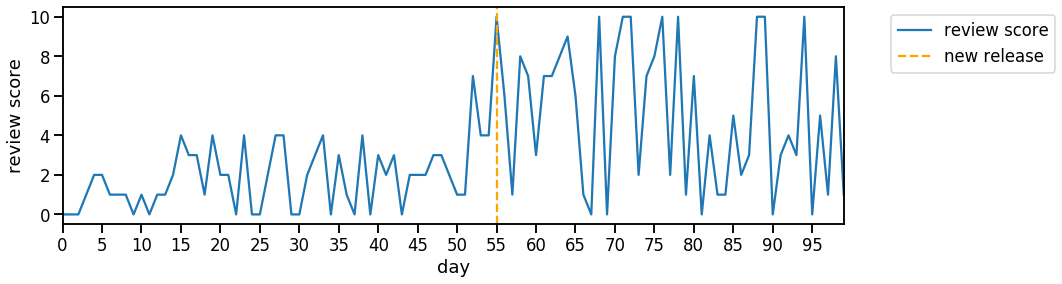

In [74]:
## plot the observations

f, ax = plt.subplots(figsize=(14,4))

df = pd.DataFrame(
    z
)

df.plot(
    kind='line', 
    y=0,
    ax=ax,
    label='review score'
)

plt.axvline(
    x=55,
    color='orange',
    linestyle='--',
    label='new release'
)

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel('day')
plt.ylabel('review score')
plt.xticks(np.arange(0,100,5))
plt.show();

# Control chart

As we discussed earlier, we can use control chart to identify data points which exceed the specified limits. Since our dataset has short value range, we'll pick $2\sigma$.

$$\text{upper control limit} = \mu + 2\sigma$$
$$\text{lower control limit} = \mu - 2\sigma$$

We assume the dataset contain review score, and it is non-negative. Thus, if the lower bound is lower than 0, we'll set it to 0.

In [75]:
## calculate upper and lower bound
upper_bound = np.mean(df[0]) + np.std(df[0]) * 2
lower_bound = np.max([
    np.mean(df[0]) - np.std(df[0]) * 2,
    0
])

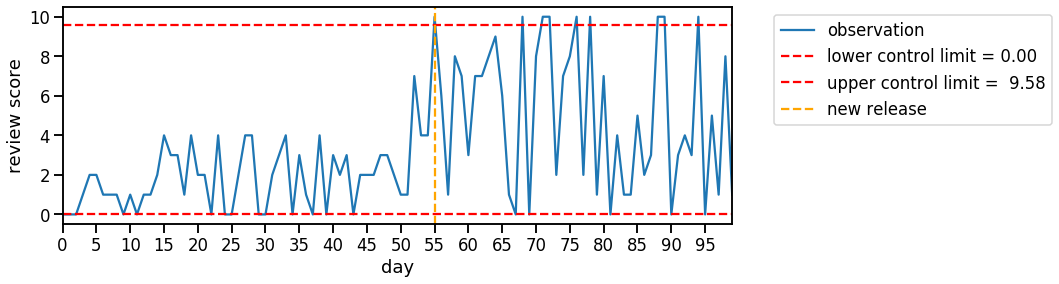

9 observations are higher than upper bound.
0 observations are below the lower bound.


In [76]:
## plot the observations, its lower and upper bound
## how many observations exceed the bounds?
## what if we change the upper and lower bound? e.g. 1 sigma

f, ax = plt.subplots(figsize=(12,4))

df.plot(
    kind='line', 
    y=0,
    ax=ax,
    label='observation'
)

plt.axhline(
    lower_bound,
    label='lower control limit = {:,.2f}'.format(np.round(lower_bound)),
    linestyle='--',
    color='red'
)

plt.axhline(
    upper_bound,
    label='upper control limit =  {:,.2f}'.format(upper_bound),
    linestyle='--',
    color='red'
)

plt.axvline(
    x=55,
    color='orange',
    linestyle='--',
    label='new release'
)

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel("day")
plt.ylabel("review score")
plt.xticks(np.arange(0,100,5))
plt.show();

print("""{} observations are higher than upper bound.
{} observations are below the lower bound.""".format(
    (df[0] > upper_bound).sum(),
      (df[0] < lower_bound).sum()
))

In [77]:
print("The first time observation occurs higher than upper limit: day {}.".format(
    df[(df[0] > upper_bound)].index[0]
))

The first time observation occurs higher than upper limit: day 55.


# Change point analysis

## 1. CUSUM Estimator

### Does the change exist?

To identify the change point with CUSUM estimator, we visualize the cumulative sum of residuals between each observation and overall mean. 

Here are the steps:
1. Calculate mean of all observations: $$\bar{y} = \frac{\Sigma_{i=1}^{n}{y_{i}}}{n}$$
2. Calculate difference of each observation to the mean: $$e_{i} = y_{i} - \bar{y}$$
3. Set cumulative sum of residuals at index 0 to 0: $$S_{0} = 0$$
4. Calculate cumulative sum of residuals: $$S_{i} = S_{i-1} + e_{i}$$

In [78]:
## implement cusum estimator

def calculate_cusum_residuals(df, observation_column=0):
    mu = df[observation_column].mean()
    df = df.shift(1)
    df['residual'] = df[observation_column] - mu
    df.loc[(df.index == 0), 'residual'] = 0
    df['residual_cumsum'] = df['residual'].cumsum()
    return df

In [79]:
df = calculate_cusum_residuals(df)

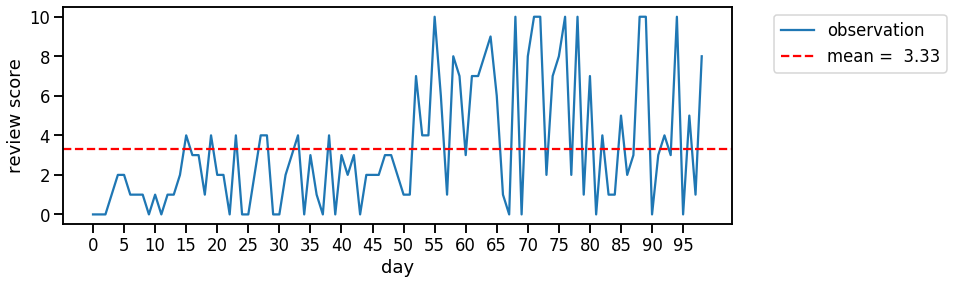

In [80]:
mask_value = (df[0] >= 0)

f, ax = plt.subplots(figsize=(12,4))

plt.plot(
    df[mask_value].reset_index()[0],
    label='observation'
);

plt.axhline(
    y=np.mean(df[0]),
    label='mean =  {:,.2f}'.format(np.mean(df[0])),
    linestyle='--',
    color='red'
)

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel("day")
plt.ylabel("review score")
plt.xticks(np.arange(0,100,5))
plt.show();

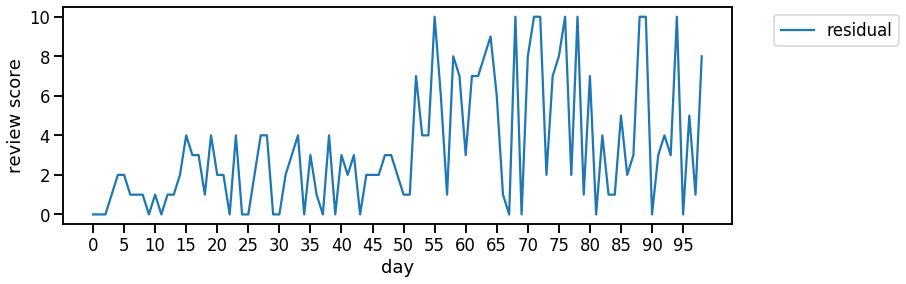

In [81]:
f, ax = plt.subplots(figsize=(12,4))

plt.plot(
    df[mask_value].reset_index()[0],
    label='residual'
)

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel("day")
plt.ylabel("review score")
plt.xticks(np.arange(0,100,5))
plt.show();

Now, let's plot the cumulative sum of residuals. 

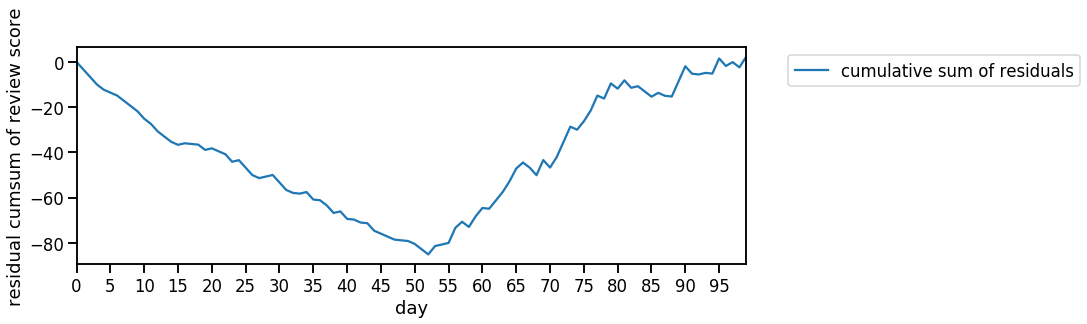

In [82]:
f, ax = plt.subplots(figsize=(12,4))

df['residual_cumsum'].plot(
    kind='line',
    ax=ax,
    label='cumulative sum of residuals'
);

plt.legend(bbox_to_anchor=[1.05,1])
plt.xlabel("day")
plt.ylabel("residual cumsum of review score")
plt.xticks(np.arange(0,100,5))
plt.show();

### When did the change occur?

> Upward slope indicates a period where the values tend to be above the overall average. A **sudden change in direction of the CUSUM indicates a sudden shift or change in the average**. Period where the CUSUM chart follows a relatively straight path indicate a period where the average did not change. - [source](https://variation.com/change-point-analysis-a-powerful-new-tool-for-detecting-changes/)

In [101]:
print("Sudden change is observed in point no: ")
df.loc[(df['residual_cumsum'] == np.min(df['residual_cumsum']))]
# df.loc[df['residual_cumsum'].argmin()]

Sudden change is observed in point no: 


,0,residual,residual_cumsum
52,1.0,-2.31,-85.12


### How different are the observations?

We can observe the mean and standard deviation before and after the change.

In [102]:
## get index of the change point
change_point = df.loc[(df['residual_cumsum'] == np.min(df['residual_cumsum']))].index.values[0]

In [103]:
## calculate mean and standard deviation before and after the change point

print("Before the change:")
print("===============")
print("Mean: {:,.2f} \t Standard deviation: {:,.2f}".format(
    df.loc[:change_point-1,
      0].mean(),
    df.loc[:change_point-1,
      0].std()
))

print("\n")
print("After the change:")
print("===============")
print("Mean: {:,.2f} \t Standard deviation: {:,.2f}".format(
    df.loc[change_point:,
      0].mean(),
    df.loc[change_point:,
      0].std()
))

Before the change:
Mean: 1.69 	 Standard deviation: 1.39


After the change:
Mean: 5.08 	 Standard deviation: 3.56


### How confident are we, that the change really exists?

CUSUM estimator is a **frequentist method**, we gain confidence interval by collecting data and observing the results in the **long run**. Since we have limited observations, we can do **sampling without replacement** (in other words, we randomly reorder the observations): 
1. determine number of iteration $N$
2. for each iteration:
    - take random sample without replacement from the observations $X^0_{1}, X^0_{2}, ..., X^0_{n}$, where $n$ = number of observations
    - calculate the sample's cumulative sum of residuals ($S^0$): $S^0_{1}, S^0_{2}, ..., S^0_{n}$
    - calculate the difference between maximum and minimum residuals in each bootstrap $$S^0_{\text{diff}} = S^0_{max} - S^0_{min}$$
    - If $S^0_{\text{diff}} < S_{\text{diff}}$, it means the result from the sample is consistent with actual observations
    
Thus, the confidence level can be calculated: $$\text{confidence level} (\%) = 100 * \frac{X}{N}$$
where $X$ represents number of iteration which has $S^0_{\text{diff}} < S_{\text{diff}}$

In [104]:
def calculate_residual_difference(df):
    ## calculate difference between maximum and minimum cumsum residuals
    resid_max = df['residual_cumsum'].max()
    resid_min = df['residual_cumsum'].min()

    resid_diff = resid_max - resid_min
    return resid_diff

In [105]:
resid_diff = calculate_residual_difference(df)
print("Observed residual difference: {:,.2f}".format(resid_diff))

Observed residual difference: 87.43


In [106]:
## calculate confidence level
N = 1000 ## determine number of iteration
X = 0 ## occurrence when sample residual difference < observed residual difference

for i in np.arange(0,N):
    _sample = pd.DataFrame(
        np.random.choice(df[0], size=df.shape[0], replace=False)
    )
    _sample = calculate_cusum_residuals(_sample)
    _sample_resid_diff = calculate_residual_difference(_sample)
    
    if _sample_resid_diff < resid_diff:
        X += 1

confidence_level = 100 * X / N
print("Confidence level: {:.2f}%".format(confidence_level))

Confidence level: 100.00%


## 2. Mean squared error (MSE) Estimator

Idea:
1. Split the observations into two segments: 
    - segment 1 = $\left\{1, ..., m\right\}$
    - segment 2 = $\left\{m+1, ..., n\right\}$
2. Calculate average value of each segment: $\bar{X}_1$ and $\bar{X}_2$
3. Observe how well the observations fit to the estimated averages: $$MSE = \Sigma_{1}^{m}(x_{i} - \bar{X}_1)^2 + \Sigma_{m+1}^{n}(x_{i} - \bar{X}_2)^2$$
4. Value of **$m$ which minimizes the mean squared error** is the **best estimate of last point before the change occurred**

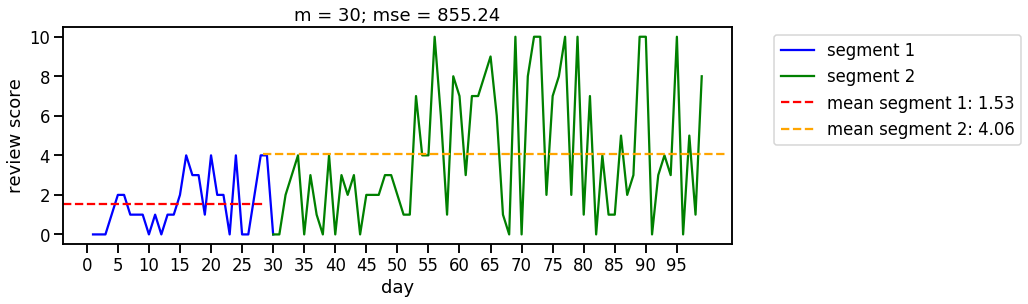

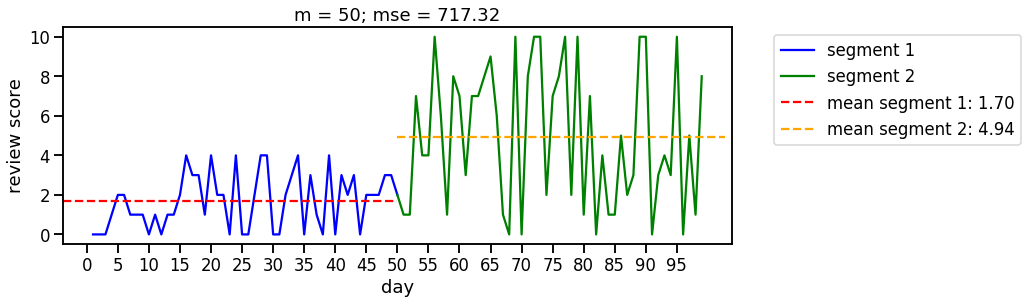

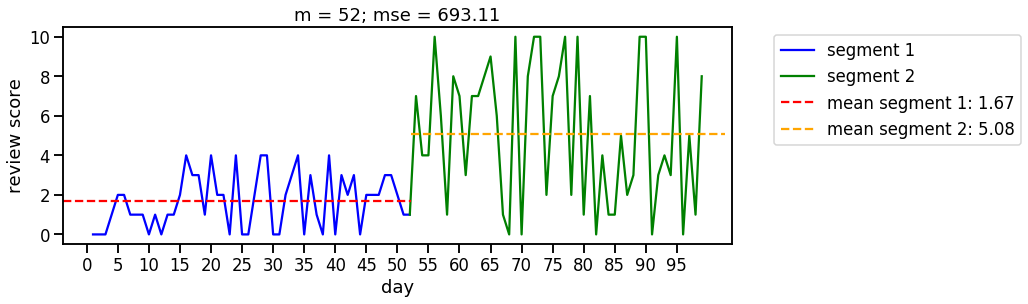

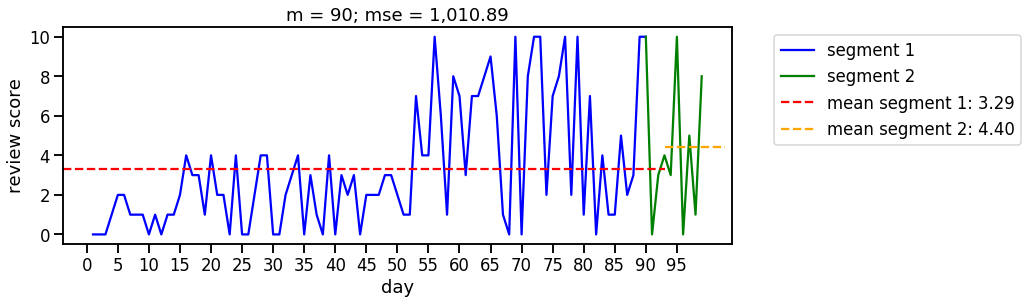

In [109]:
mse_estimator = pd.DataFrame({
    'm': [],
    'mse': []
})

## calculate mse for each m
for i in np.arange(df.shape[0]):
    segment_1 = df[0].loc[:i]
    segment_2 = df[0].loc[i:]
    
    mean_segment_1 = segment_1.mean()
    mean_segment_2 = segment_2.mean()
    
    mse = np.power((segment_1 - mean_segment_1),2).sum() + np.power((segment_2 - mean_segment_2),2).sum()
    mse_estimator = mse_estimator.append(
        pd.DataFrame({
                'm': i,
                'mse': mse
            }, index=[0])  
    )
    
    if i in [30, 50, 52, 90]:
        f, ax = plt.subplots(figsize=(12,4))
        
        plt.plot(
            segment_1,
            label='segment 1',
            color='blue'
        )
        
        plt.plot(
            segment_2,
            label='segment 2',
            color='green'
        )
        
        plt.axhline(
            y=mean_segment_1,
            xmin=segment_1.index.min() / df.shape[0],
            xmax=segment_1.index.max() / df.shape[0],
            linestyle='--',
            color='red',
            label='mean segment 1: {:,.2f}'.format(mean_segment_1)
        )
        
        plt.axhline(
            y=mean_segment_2,
            xmin=segment_2.index.min() / df.shape[0],
            xmax=segment_2.index.max() / df.shape[0],
            linestyle='--',
            color='orange',
            label='mean segment 2: {:,.2f}'.format(mean_segment_2)
        )
        
        plt.legend(bbox_to_anchor=[1.05,1])
        plt.xlabel("day")
        plt.ylabel("review score")
        plt.xticks(np.arange(0,100,5))
        plt.title('m = {}; mse = {:,.2f}'.format(i, mse))
        plt.show();

In [108]:
## find the last point before the change occurred

change_point_lag1 = mse_estimator.loc[
    (mse_estimator['mse'] == mse_estimator['mse'].min()),
    'm'].values[0]

print("Last point before the change occurred: {}".format(change_point_lag1))

display(
    df.loc[change_point_lag1:change_point_lag1+1]
)

Last point before the change occurred: 52.0


,0,residual,residual_cumsum
52,1.0,-2.31,-85.12
53,7.0,3.69,-81.43


**Bonus!**

## 3. Bayesian approach

Instead of using point estimate, we calculate the probability distribution of the change point.

Ideas:
1. Set prior distribution of $\mu_{1}$, $\mu_{2}$, overall $\sigma$
2. The change point could occur in $\tau \in \left\{1, ..., n\right\}$
3. We assign $$\mu = \begin{cases}\mu_{1} & \text{if} ~ \tau \ge t \\\mu_{2} & \text{if} ~ \tau < t \end{cases}$$
4. Produce the sample!

In [96]:
import pymc3 as pm

## set number of sample
## set t = time, from 0 to length of observations
samples = 5000 ## number of iteration
t = np.arange(0, len(z)) ## array of observation positions (time)

with pm.Model() as model:
    ## define uniform priors for the mean values
    mu_a = pm.Uniform('mu_a', 0, 10)
    mu_b = pm.Uniform('mu_b', 0, 10)
    sigma = pm.HalfCauchy('sigma', np.std(z))
    tau = pm.DiscreteUniform('tau', t.min(), t.max())
    
    ## define stochastic variable mu
    mu = pm.math.switch(tau >= t, mu_a, mu_b)
    
    observation = pm.Normal('observation', mu, sigma, observed=z)
    
    trace = pm.sample(samples, step=pm.NUTS())
    ## use burned trace
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, mu_b, mu_a]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:26<00:00, 417.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


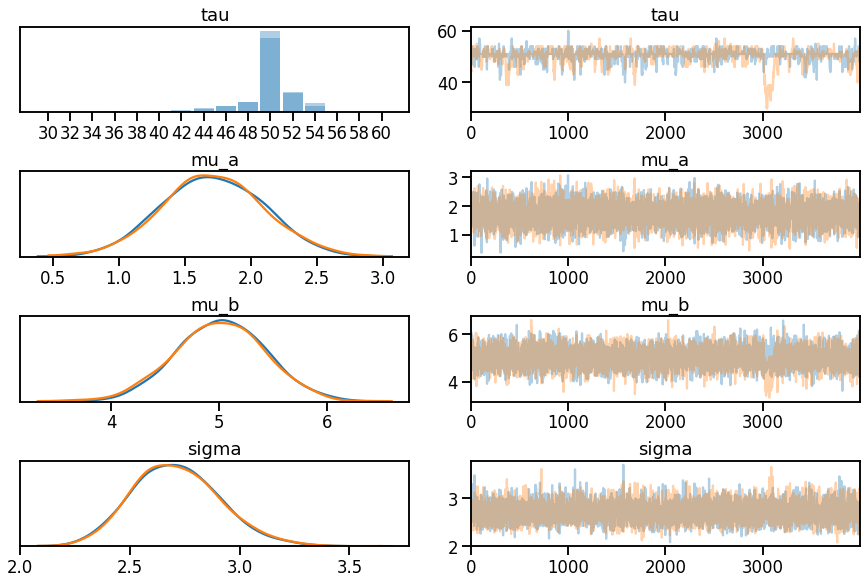

In [97]:
## plot the sample
pm.traceplot(burned_trace);

### When did the change occur?

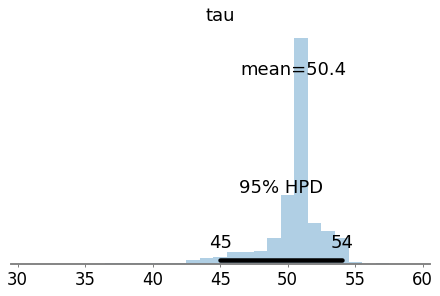

In [98]:
## plot posterior distribution of tau
pm.plot_posterior(
    burned_trace,
    var_names=['tau'],
    credible_interval=0.95
);

### How different are the observations?

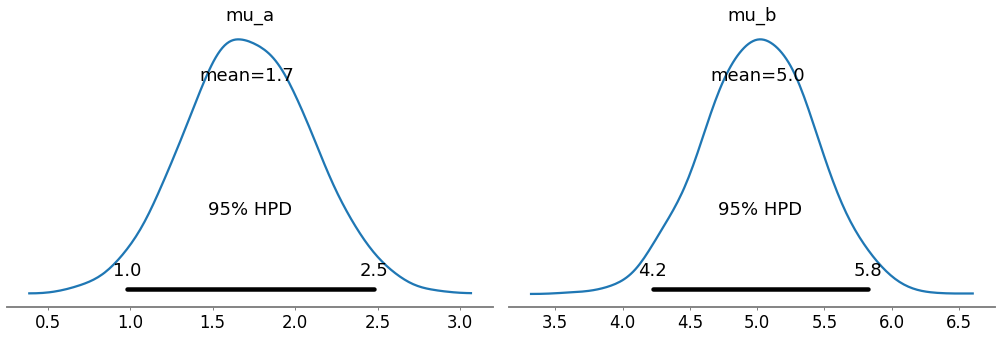

In [99]:
## plot posterior distribution of mu_a, mu_b
pm.plot_posterior(
    burned_trace,
    var_names=['mu_a', 'mu_b'],
    credible_interval=0.95
);

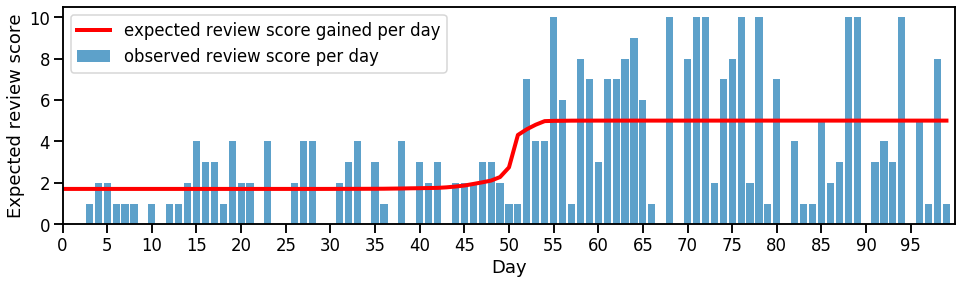

In [100]:
f, ax = plt.subplots(figsize=(16,4))

N = burned_trace['tau'].shape[0] ## number of sample
n_count_data = len(z) ## number of observations

expected_review_score = np.zeros(n_count_data)

for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < burned_trace['tau']
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the mu_1 "regime") or
    #  "after" (in the mu_2 "regime") the switchpoint.
    # by taking the posterior sample of mu_1 and mu_2 accordingly, 
    # we can average over all samples to get an expected value for lambda on that day.
    expected_review_score[day] = (burned_trace['mu_a'][ix].sum()
                                   + burned_trace['mu_b'][~ix].sum()) / N


plt.plot(
    range(n_count_data), 
    expected_review_score, 
    lw=4, 
    color="red",
    label="expected review score gained per day"
)

plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected review score")
plt.xticks(np.arange(0,100,5))

plt.bar(
    np.arange(n_count_data),
    z,
    color="#348ABD",
    alpha=0.8,
    label="observed review score per day"
)

plt.legend(loc="upper left");